<a href="https://colab.research.google.com/github/tortoisehare/TSR-GAN/blob/master/metrics_TSRClassifier_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Author: Stephanie Tietz

LeNet5 model design and grayscale preprocessing idea from: mohamedameen93 on full German Traffic Sign dataset

https://github.com/mohamedameen93/German-Traffic-Sign-Classification-Using-TensorFlow

Regularization options provided, Adadelta or Adam optimizer, trained on German TS Dataset plus "not a sign" images, optimized for 3 classes first then expanding to 44

Multiclass Image Classification in TensorFlow

In [1]:
import numpy as np
np.random.seed(1187) #to help reproduce

from __future__ import print_function
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import csv
#import random
#import cv2
from skimage.filters import rank
import skimage.morphology as morp
from sklearn.metrics import confusion_matrix

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras import optimizers
#from keras.utils import np_utils
#from keras import backend as K


Using TensorFlow backend.


In [2]:
#upload data
from google.colab import files

uploaded = files.upload()

#traindata = np.load('smalltrain.npy') #only 3 classes, both circle signs
#traindata = np.load('alltrain.npy') #all classes

#testdata = np.load('smalltest.npy')
#testdata = np.load('alltest.npy')

import pickle


training_file = 'train.p'
testing_file = 'test.p'
validation_file = 'valid.p'

with open(training_file, mode='rb') as f:
    tstrain = pickle.load(f)
with open(testing_file, mode='rb') as f:
    tstest = pickle.load(f)
with open(validation_file, mode='rb') as f:
    tsvalid = pickle.load(f)
 

Saving test.p to test.p
Saving train.p to train.p
Saving valid.p to valid.p


In [3]:

X_train, Y_train = tstrain['features'], tstrain['labels']
X_valid, Y_valid = tsvalid['features'], tsvalid['labels']
X_test, Y_test = tstest['features'], tstest['labels']

num_train = X_train.shape[0]
num_test = X_test.shape[0]
num_valid = X_valid.shape[0]

print(Y_train.shape)
print(Y_valid.shape)
print(Y_test.shape)

(34799,)
(4410,)
(12630,)


In [0]:
#signs = []
#with open('signnames.csv', 'r') as csvfile:
    #signnames = csv.reader(csvfile, delimiter=',')
    #next(signnames,None)
    #for row in signnames:
     #   signs.append(row[1])
    #csvfile.close()

In [4]:
#START OF DATA PREPROCESSING
#Shuffle

from sklearn.utils import shuffle

#Randomize (shuffle) the data
print(Y_train)
X_train, Y_train = shuffle(X_train, Y_train)
#X_valid, Y_valid = shuffle(X_valid, Y_valid)
#X_test, Y_test = shuffle(X_test, Y_test)
print(Y_train)



[41 41 41 ... 25 25 25]
[25  3  2 ... 13 18 34]


In [5]:
#Make grayscale
print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)
grayscale = [0.299,0.587,0.144]

X_test = np.dot(X_test, grayscale)
X_train = np.dot(X_train, grayscale)
X_valid = np.dot(X_valid, grayscale)
print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)




(34799, 32, 32, 3)
(12630, 32, 32, 3)
(4410, 32, 32, 3)
(34799, 32, 32)
(12630, 32, 32)
(4410, 32, 32)


In [6]:
#Normalize data
X_train = np.array(X_train)/255
X_test = np.array(X_test)/255
X_valid = np.array(X_valid)/255
print(X_train.shape)

(34799, 32, 32)


In [7]:
#Expand dimensions to fit 4D input array

X_train = np.expand_dims(X_train,-1)
print(X_train.shape)

X_test = np.expand_dims(X_test,-1)
print(X_test.shape)

X_valid = np.expand_dims(X_valid,-1)
print(X_valid.shape)

(34799, 32, 32, 1)
(12630, 32, 32, 1)
(4410, 32, 32, 1)


In [0]:
#compute mean image of training set and subtract from training images (not test images)
#chann_index_swap = np.swapaxes(X_train,0,3)
#mean_image = [[[sum(pixel)/len(pixel) for pixel in col] for col in row] for row in chann_index_swap]
#mean_image = np.swapaxes(mean_image,0,2)
#mean_image = np.swapaxes(mean_image,0,1)

#X_train = X_train - mean_image
#print(X_train.shape)

In [0]:
num_classes = 43 #change to 44 for alldata

assert(len(X_train)==len(Y_train))
n_train = len(X_train)
assert(len(X_test)==len(Y_test))
n_test = len(X_test)

#Useful image variables
im_rows = 32
im_cols = 32
image_shape = (32, 32, 1)


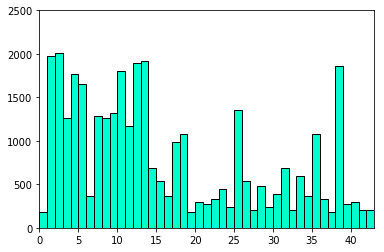

Train Class with most examples:
2 2010
Class with least examples:
37 180


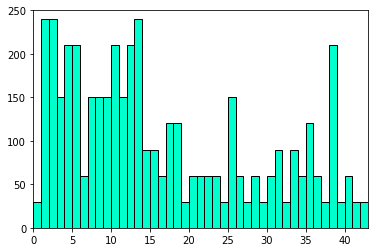

Valid Class with most examples:
13 240
Class with least examples:
42 30


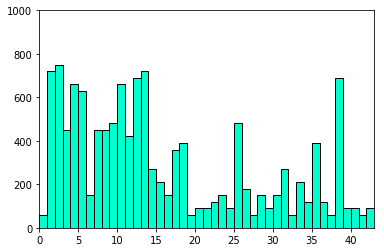

Test Class with most examples:
2 750
Class with least examples:
41 60


In [9]:
#Histogram visualization of classes
hist_data = np.histogram(Y_train, bins=range(num_classes+1))
hist_map = {}
for occr,i in zip(hist_data[0], hist_data[1]):
  hist_map[occr] = i

plt.hist(Y_train, bins=range(num_classes+1), color = '#00ffCC', histtype='bar', ec='black')
plt.axis([0,num_classes,0,2500])
plt.show()
print("Train Class with most examples:")
print(hist_map[np.amax(hist_data[0])],np.amax(hist_data[0]))
print("Class with least examples:")
print(hist_map[np.amin(hist_data[0])],np.amin(hist_data[0]))

hist_data = np.histogram(Y_valid, bins=range(num_classes+1))
hist_map = {}
for occr,i in zip(hist_data[0], hist_data[1]):
  hist_map[occr] = i

plt.hist(Y_valid, bins=range(num_classes+1), color = '#00ffCC', histtype='bar', ec='black')
plt.axis([0,num_classes,0,250])
plt.show()
print("Valid Class with most examples:")
print(hist_map[np.amax(hist_data[0])],np.amax(hist_data[0]))
print("Class with least examples:")
print(hist_map[np.amin(hist_data[0])],np.amin(hist_data[0]))

hist_data = np.histogram(Y_test, bins=range(num_classes+1))
hist_map = {}
for occr,i in zip(hist_data[0], hist_data[1]):
  hist_map[occr] = i

plt.hist(Y_test, bins=range(num_classes+1), color = '#00ffCC', histtype='bar', ec='black')
plt.axis([0,num_classes,0,1000])
plt.show()
print("Test Class with most examples:")
print(hist_map[np.amax(hist_data[0])],np.amax(hist_data[0]))
print("Class with least examples:")
print(hist_map[np.amin(hist_data[0])],np.amin(hist_data[0]))


In [0]:
class LeNet:  

    def __init__(self, n_out=43, mu=0, sigma=0.1, learning_rate=0.001):
        # Hyperparameters
        self.mu = mu
        self.sigma = sigma

        # Layer 1 (Convolutional): Input = 32x32x1. Output = 28x28x6.
        self.filter1_width = 5
        self.filter1_height = 5
        self.input1_channels = 1
        self.conv1_output = 6
        # Weight and bias
        self.conv1_weight = tf.Variable(tf.truncated_normal(
            shape=(self.filter1_width, self.filter1_height, self.input1_channels, self.conv1_output),
            mean = self.mu, stddev = self.sigma))
        self.conv1_bias = tf.Variable(tf.zeros(self.conv1_output))
        # Apply Convolution
        self.conv1 = tf.nn.conv2d(x, self.conv1_weight, strides=[1, 1, 1, 1], padding='VALID') + self.conv1_bias
        
        # Activation:
        self.conv1 = tf.nn.relu(self.conv1)
        
        # Pooling: Input = 28x28x6. Output = 14x14x6.
        self.conv1 = tf.nn.max_pool(self.conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        
        # Layer 2 (Convolutional): Output = 10x10x16.
        self.filter2_width = 5
        self.filter2_height = 5
        self.input2_channels = 6
        self.conv2_output = 16
        # Weight and bias
        self.conv2_weight = tf.Variable(tf.truncated_normal(
            shape=(self.filter2_width, self.filter2_height, self.input2_channels, self.conv2_output),
            mean = self.mu, stddev = self.sigma))
        self.conv2_bias = tf.Variable(tf.zeros(self.conv2_output))
        # Apply Convolution
        self.conv2 = tf.nn.conv2d(self.conv1, self.conv2_weight, strides=[1, 1, 1, 1], padding='VALID') + self.conv2_bias
        
        # Activation:
        self.conv2 = tf.nn.relu(self.conv2)
        
        # Pooling: Input = 10x10x16. Output = 5x5x16.
        self.conv2 = tf.nn.max_pool(self.conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        
        # Flattening: Input = 5x5x16. Output = 400.
        self.fully_connected0 = Flatten()(self.conv2)
        
        # Layer 3 (Fully Connected): Input = 400. Output = 120.
        self.connected1_weights = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = self.mu, stddev = self.sigma))
        self.connected1_bias = tf.Variable(tf.zeros(120))
        self.fully_connected1 = tf.add((tf.matmul(self.fully_connected0, self.connected1_weights)), self.connected1_bias)
        
        # Activation:
        self.fully_connected1 = tf.nn.relu(self.fully_connected1)
    
        # Layer 4 (Fully Connected): Input = 120. Output = 84.
        self.connected2_weights = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = self.mu, stddev = self.sigma))
        self.connected2_bias = tf.Variable(tf.zeros(84))
        self.fully_connected2 = tf.add((tf.matmul(self.fully_connected1, self.connected2_weights)), self.connected2_bias)
        
        # Activation.
        self.fully_connected2 = tf.nn.relu(self.fully_connected2)
    
        # Layer 5 (Fully Connected): Input = 84. Output = 43.
        self.output_weights = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = self.mu, stddev = self.sigma))
        self.output_bias = tf.Variable(tf.zeros(43))
        self.logits =  tf.add((tf.matmul(self.fully_connected2, self.output_weights)), self.output_bias)

        # Training operation
        self.one_hot_y = tf.one_hot(y, n_out)
        self.cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=self.logits, labels=self.one_hot_y)
        self.loss_operation = tf.reduce_mean(self.cross_entropy)
        self.optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
        self.training_operation = self.optimizer.minimize(self.loss_operation)

        # Accuracy operation
        self.correct_prediction = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.one_hot_y, 1))
        self.accuracy_operation = tf.reduce_mean(tf.cast(self.correct_prediction, tf.float32))
        
        self.predicted = tf.argmax(self.logits,1)
        self.actual = tf.argmax(self.one_hot_y, 1)
        self.TP = tf.count_nonzero(self.predicted*self.actual)
        self.TN = tf.count_nonzero((self.predicted-1)*(self.actual-1))
        self.FP = tf.count_nonzero(self.predicted*(self.actual-1))
        self.FN = tf.count_nonzero((self.predicted-1)*self.actual)
        self.precision_op = tf.divide(self.TP,(self.TP + self.FP))
        self.recall_op = tf.divide(self.TP, (self.TP + self.FN))
        self.f1_op = tf.divide((2*self.precision_op*self.recall_op),(self.precision_op + self.recall_op))

        # Saving all variables
        self.saver = tf.train.Saver()
    
    def y_predict(self, X_data, BATCH_SIZE=64):
        num_examples = len(X_data)
        y_pred = np.zeros(num_examples, dtype=np.int32)
        sess = tf.get_default_session()
        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x = X_data[offset:offset+BATCH_SIZE]
            y_pred[offset:offset+BATCH_SIZE] = sess.run(tf.argmax(self.logits, 1), 
                               feed_dict={x:batch_x, keep_prob:1, keep_prob_conv:1})
        return y_pred
    
    def evaluate(self, X_data, y_data, BATCH_SIZE=64):
        num_examples = len(X_data)
        total_accuracy = 0
        sess = tf.get_default_session()
        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
            accuracy = sess.run(self.accuracy_operation, 
                                feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0, keep_prob_conv: 1.0 })
            total_accuracy += (accuracy * len(batch_x))
        return total_accuracy / num_examples
      
    def getrecall(self, X_data, y_data, BATCH_SIZE=64):
        num_examples = len(X_data)
        total_accuracy = 0
        total_precision = 0
        total_recall = 0
        total_F1 = 0
        sess = tf.get_default_session()
        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]

            recall = sess.run(self.recall_op, 
                                feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0, keep_prob_conv: 1.0 })
            total_recall += (recall * len(batch_x))

        return total_recall/num_examples
    
    def getprecision(self, X_data, y_data, BATCH_SIZE=64):
        num_examples = len(X_data)
        total_precision = 0
        sess = tf.get_default_session()
        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]

            precision = sess.run(self.precision_op, 
                                feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0, keep_prob_conv: 1.0 })
            total_precision += (precision * len(batch_x))

        return total_precision/num_examples
    
    def getf1(self, X_data, y_data, BATCH_SIZE=64):
        num_examples = len(X_data)

        total_f1 = 0
        sess = tf.get_default_session()
        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]

            f1 = sess.run(self.f1_op, 
                                feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0, keep_prob_conv: 1.0 })
            total_f1 += (f1 * len(batch_x))
        return total_f1/num_examples

In [0]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))

keep_prob = tf.placeholder(tf.float32)       # For fully-connected layers
keep_prob_conv = tf.placeholder(tf.float32)  # For convolutional layers

EPOCHS = 30
BATCH_SIZE = 20
DIR = 'Saved_Models'

In [0]:
LeNet_Model = LeNet(n_out = num_classes)
model_name = "LeNet"

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(Y_train)
    print("Training ...")
    print()
    for i in range(EPOCHS):
        #X_train, Y_train = shuffle(X_train, Y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], Y_train[offset:end]
            sess.run(LeNet_Model.training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob : 0.6, keep_prob_conv: 0.8})
            
        validation_accuracy = LeNet_Model.evaluate(X_valid, Y_valid)
        print("EPOCH {} : Validation Accuracy = {:.3f}%".format(i+1, (validation_accuracy*100)))
        valid_recall = LeNet_Model.getrecall(X_valid, Y_valid)
        print("EPOCH {} : Validation Recall = {:.3f}%".format(i+1, (valid_recall*100)))
        valid_prec = LeNet_Model.getprecision(X_valid, Y_valid)
        print("EPOCH {} : Validation Precision = {:.3f}%".format(i+1, (valid_prec*100)))
        valid_f1 = LeNet_Model.getf1(X_valid, Y_valid)
        print("EPOCH {} : Validation F1 = {:.3f}%".format(i+1, (valid_f1*100)))
    LeNet_Model.saver.save(sess, os.path.join(DIR, model_name))
    print("Model saved")

Training ...

EPOCH 1 : Validation Accuracy = 83.492%
EPOCH 1 : Validation Recall = 51.247%
EPOCH 1 : Validation Precision = 52.367%
EPOCH 1 : Validation F1 = 51.709%
EPOCH 2 : Validation Accuracy = 88.707%
EPOCH 2 : Validation Recall = 51.735%
EPOCH 2 : Validation Precision = 52.388%
EPOCH 2 : Validation F1 = 52.013%


Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from Saved_Models/LeNet
Test Accuracy = 91.2%


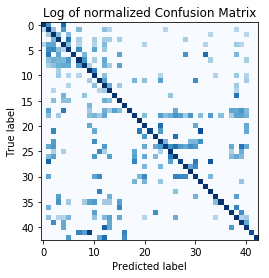

"\n\nplt.plot(history.history['acc'])\nplt.plot(history.history['val_acc'])\nplt.title('Model accuracy')\nplt.ylabel('Accuracy')\nplt.xlabel('Epoch')\nplt.legend(['Train', 'Test'], loc='upper left')\nplt.show()\n\n# Plot training & validation loss values\nplt.plot(history.history['loss'])\nplt.plot(history.history['val_loss'])\nplt.title('Model loss')\nplt.ylabel('Loss')\nplt.xlabel('Epoch')\nplt.legend(['Train', 'Test'], loc='upper left')\nplt.show()\n"

In [0]:
with tf.Session() as sess:
    LeNet_Model.saver.restore(sess, os.path.join(DIR, "LeNet"))
    y_pred = LeNet_Model.y_predict(X_test)
    test_accuracy = sum(Y_test == y_pred)/len(Y_test)
    print("Test Accuracy = {:.1f}%".format(test_accuracy*100))
    

cm = confusion_matrix(Y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm = np.log(.0001 + cm)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Log of normalized Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
